In [1]:
## tools

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [6]:
wiki.invoke("What is Diwali")

'Page: Diwali\nSummary: Dipavali (IAST: Dīpāvalī), commonly known as Diwali (), is the Hindu festival of lights, with variations celebrated in other Indian religions such as Jainism and Sikhism. It symbolises the spiritual victory of Dharma over Adharma, light over darkness, good over evil, and knowledge over ignorance. Diwali is celebrated during the Hindu lunisolar months of Ashvin (according to the amanta tradition) and Kārtika – between around mid-October and mid-November. The celebrations gen'

In [7]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


In [ ]:
### Travily Search Tool

from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()


/var/folders/vy/mjpzsrz556x_tldxr79gfxxm0000gn/T/ipykernel_79293/3556693048.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [9]:
tavily.invoke("Provide me the latest news")

[{'title': 'CNN: Breaking News, Latest News and Videos',
  'url': 'https://www.cnn.com/',
  'content': '520 5th Avenue [...] A gift bag featuring a cat wrapped in Christmas tree decorations\n\n## Art and Style [...] ## For Subscribers',
  'score': 0.35756752},
 {'title': 'Headlines for January 02, 2026 | Democracy Now!',
  'url': 'https://www.democracynow.org/2026/1/2/headlines',
  'content': "## Pentagon Says It Blew Up 5 More Boats in Caribbean and Pacific, Killing at Least 8 [...] # You turn to us for voices you won't hear anywhere else.\n\nSign up for Democracy Now!'s Daily Digest to get our latest headlines and stories delivered to your inbox every day.\n\n##### Menu\n\n##### Menu\n\n##### Editions\n\n##### Follow\n\n##### Democracy Now!\n\n# HeadlinesJanuary 02, 2026\n\n##### Media Options\n\n##### Media Options\n\n## Zohran Mamdani Sworn In as New York’s First Muslim and First Democratic Socialist Mayor [...] ## “We Are Locked and Loaded”: Trump Threatens to Attack Iran as Prote

In [10]:
## combine all the above tools in the list
tools = [arxiv, wiki, tavily]

In [11]:
## Initialize the LLM model
from langchain_groq import ChatGroq

llm = ChatGroq(
    model = "qwen/qwen3-32b",
)


In [16]:
llm.invoke("What is AI")

AIMessage(content='<think>\nOkay, so I need to understand what AI is. Hmm, I\'ve heard the term before, but I\'m not exactly sure what it means. Let me start by breaking it down. AI stands for Artificial Intelligence, right? But what does that actually mean? Maybe it\'s like making machines smart? But how?\n\nI remember seeing sci-fi movies where robots have AI, like in Terminator or something. But that\'s probably not the real deal. Real AI must be more about software or algorithms. Maybe it\'s about making computers do things that humans are good at, like learning, problem-solving, or recognizing patterns.\n\nWait, I think there\'s something called Machine Learning that\'s part of AI. Is that where the computer learns from data? Like, if you give it a bunch of examples, it can figure out patterns and make decisions without being explicitly programmed? So, instead of writing code for every possible scenario, you let the machine learn from the data. That sounds right.\n\nBut then there

In [13]:
llm_with_tools = llm.bind_tools(tools=tools,)

In [14]:
llm_with_tools.invoke("What is the recent news on AI?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news on AI. I need to figure out which tool to use here. Let me check the available functions.\n\nFirst, there\'s the arxiv function, which is for querying academic papers. But the user is asking about recent news, not research papers. So probably not arxiv.\n\nNext, the wikipedia function. Wikipedia does have information on AI, but it\'s more of a general knowledge source. Recent news might not be covered there immediately. Plus, Wikipedia entries are more about established information, not the latest updates.\n\nThen there\'s the tavily_search_results_json function. The description says it\'s optimized for comprehensive, accurate, and trusted results, especially for current events. That sounds perfect for finding recent news on AI. The user wants up-to-date information, so a search engine like Tavily would be the best choice here.\n\nI should make sure to structure the query properly. T

Workflow

In [17]:
## State Schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


In [18]:
class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

In [19]:
### Entire chatbot with langgraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

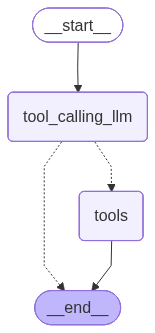

In [21]:
### Node definition

def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph

builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edges

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
from langchain_core.messages import HumanMessage,AIMessage

messages = graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (rbgxdbj0z)
 Call ID: rbgxdbj0z
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [26]:
messages = graph.invoke({"messages":"Hi, How are you?"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, How are you?
================================== Ai Message ==================================

Hello! I'm doing well. How can I assist you today?
